In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../sci_style.py')

# Load Data

In [57]:
# session = 'Mary-Anesthesia-20160912-02'
# session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160826-02'
# session = 'MrJones-Anesthesia-20160107-01'
# session = 'Mary-Anesthesia-20160822-02'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160121-01'
# session = 'Mary-Anesthesia-20160831-02'
session = 'MrJones-Anesthesia-20160105-01'

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [58]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [59]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [60]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

# Load Results

In [61]:
# max_freq = 500
# max_unstable_freq = 125
norm = False

In [62]:
results_dict = {}
norm_dir = "NORMED" if norm else "NOT_NORMED"
for area in os.listdir(os.path.join(results_dir, session, norm_dir)):
    results_dict[area] = None
    for f in os.listdir(os.path.join(results_dir, session, norm_dir, area)):
        t = float(f.split('_')[0])
        df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, norm_dir, area, f)))
        if len(df) > 0:
            df['area'] = area
            df['start_time'] = t
            df['end_time'] = t + df.window*dt
            df['start_ind'] = int(t/dt)
            df['end_ind'] = int(t/dt) + df.window

            if results_dict[area] is None:
                results_dict[area] = df
            else:
                results_dict[area] = pd.concat([results_dict[area], df])
        else:
            print(f"{area}/{f} is empty")
    results_dict[area] = results_dict[area].sort_values('start_time')

# Plot 1

In [63]:
top_percent = 5
percentile_str = f"Top {top_percent}% of Stability Parameters"

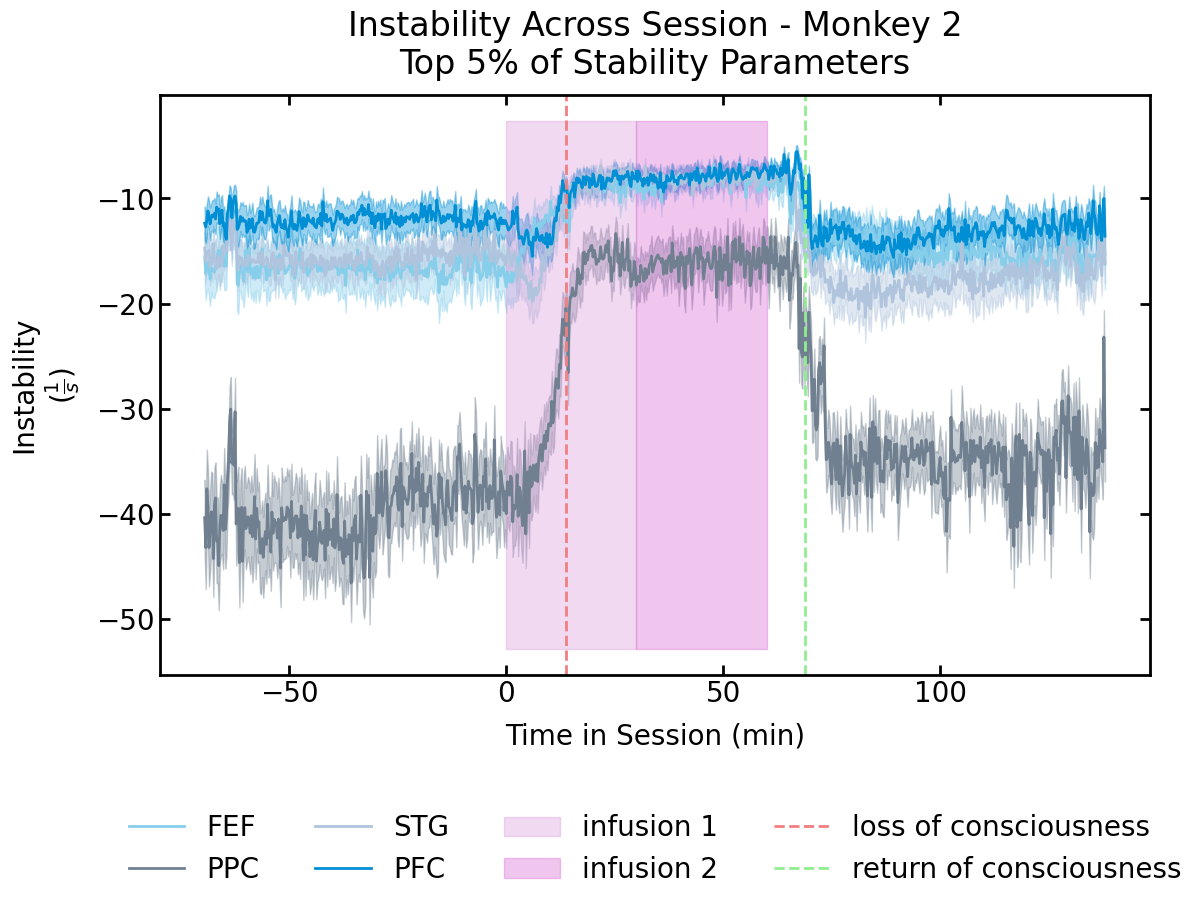

In [64]:
plt.figure(figsize=(12, 8))
filter_times = False
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}
for area in results_dict.keys():
    if area != 'all':
        if filter_times:
            filter_inds = np.logical_and(results_dict[area].start_time >= session_info['drugStart'][0] - 15*60, results_dict[area].start_time <= eyes_open + 20*60)
        else:
            filter_inds = [True]*len(results_dict[area])
        time_vals = (results_dict[area][filter_inds].start_time - session_info['drugStart'][0])/60
        stability_mean = results_dict[area][filter_inds].stability_params.apply(lambda x: x[:int((top_percent/100)*len(x))].mean())
        stability_std_error = results_dict[area][filter_inds].stability_params.apply(lambda x: x[:int((top_percent/100)*len(x))].std()/np.sqrt(int((top_percent/100)*len(x))))
        plt.plot(time_vals, stability_mean, color=area_colors[area], label=area_labels[area])
        plt.fill_between(time_vals, stability_mean - stability_std_error, stability_mean + stability_std_error, color=area_colors[area], alpha=0.4)
# title_str = f"{session}\n{percentile_str}"
monkey_num = 2 if 'Jones' in session else 1
title_str = f"Instability Across Session - Monkey {monkey_num}\n{percentile_str}"
plt.title(title_str)
plt.xlabel('Time in Session (min)')
plt.ylabel('Instability\n' r'($\frac{1}{s}$)')
ylim = plt.ylim()
plt.fill_betweenx(ylim, (session_info['drugStart'][0] - session_info['drugStart'][0])/60, (session_info['drugEnd'][0] - session_info['drugStart'][0])/60, color='plum', alpha=0.4, label='infusion 1')
plt.fill_betweenx(ylim, (session_info['drugStart'][1] - session_info['drugStart'][0])/60, (session_info['drugEnd'][1] - session_info['drugStart'][0])/60, color='orchid', alpha=0.4, label='infusion 2')
plt.axvline((eyes_close - session_info['drugStart'][0])/60, linestyle='--', color='lightcoral', label='loss of consciousness')
plt.axvline((eyes_open - session_info['drugStart'][0])/60, linestyle='--', color='lightgreen', label='return of consciousness')
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', ncol=4)
plt.show()

# Plot 2

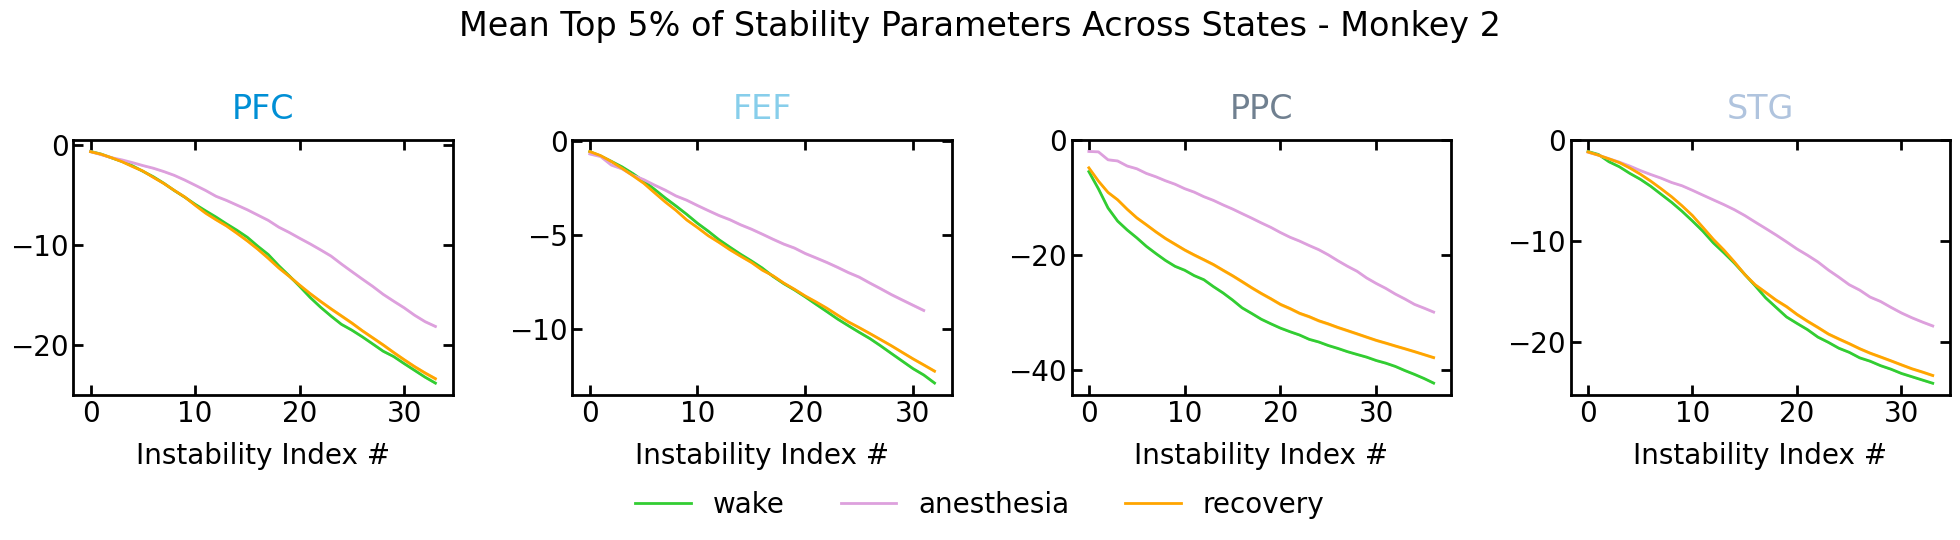

In [152]:
section_colors = {
    'wake': 'limegreen',
    'anesthesia': 'plum',
    'recovery': 'orange'
}

area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'indigo'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}


# areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']
areas = ['vlPFC', 'FEF', '7b', 'CPB']
# areas = ['FEF', '7b', 'CPB']

percentile_low = 0
percentile_high = 5

if percentile_low == 0:
    percentile_str = f"Top {percentile_high}% of Stability Parameters"
else:
    percentile_str = f"Top {percentile_low}% to {percentile_high}% of Stability Parameters"

# figsize= (12, 8)
figsize=(20, 5)
fig, axs = plt.subplots(1, len(areas), figsize=figsize)
spectra = {}
for i in range(len(areas)):
#         ax = axs[int(i/2)][i%2]
    ax = axs[i]
    area = areas[i]
    lns = []
    spectra[area] = {}
    for section in ['wake', 'anesthesia', 'recovery']:
#         for section in ['wake', 'anesthesia']:
        section_inds = np.logical_and(results_dict[area].start_time >= section_times[section][0], results_dict[area].start_time < section_times[section][1])
        min_length = np.min(results_dict[area][section_inds].stability_params.apply(lambda x: int(len(x)*percentile_high/100) - int(len(x)*percentile_low/100)))
        full_spectrum = np.vstack(results_dict[area][section_inds].stability_params.apply(lambda x: x[int(len(x)*percentile_low/100):int(len(x)*percentile_low/100) + min_length]).to_numpy())
        mean_spectrum = full_spectrum.mean(axis=0)
        se_spectrum = full_spectrum.std(axis=0)/np.sqrt(len(section_inds))
        lns += ax.plot(mean_spectrum, c=section_colors[section], label=section)
        ax.fill_between(np.arange(len(mean_spectrum)), mean_spectrum - se_spectrum, mean_spectrum + se_spectrum, color=section_colors[section], alpha=0.4)
        if section in ['wake', 'anesthesia']:
            spectra[area][section] = full_spectrum
    ax.set_title(area_labels[area], c=area_colors[area])
    ax.set_xlabel("Instability Index #")
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.01), loc='center', ncol=3)
monkey_num = 2 if 'Jones' in session else 1
plt.suptitle(f"Mean {percentile_str} Across States - Monkey {monkey_num}")
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, f"neural_ret2_{session}.png"), transparent=True, bbox_inches='tight')
plt.show()

# Plot 3

60.0

In [159]:
15*60/stride

60.0

In [157]:
criticality_prob_dist.shape

(430, 40)

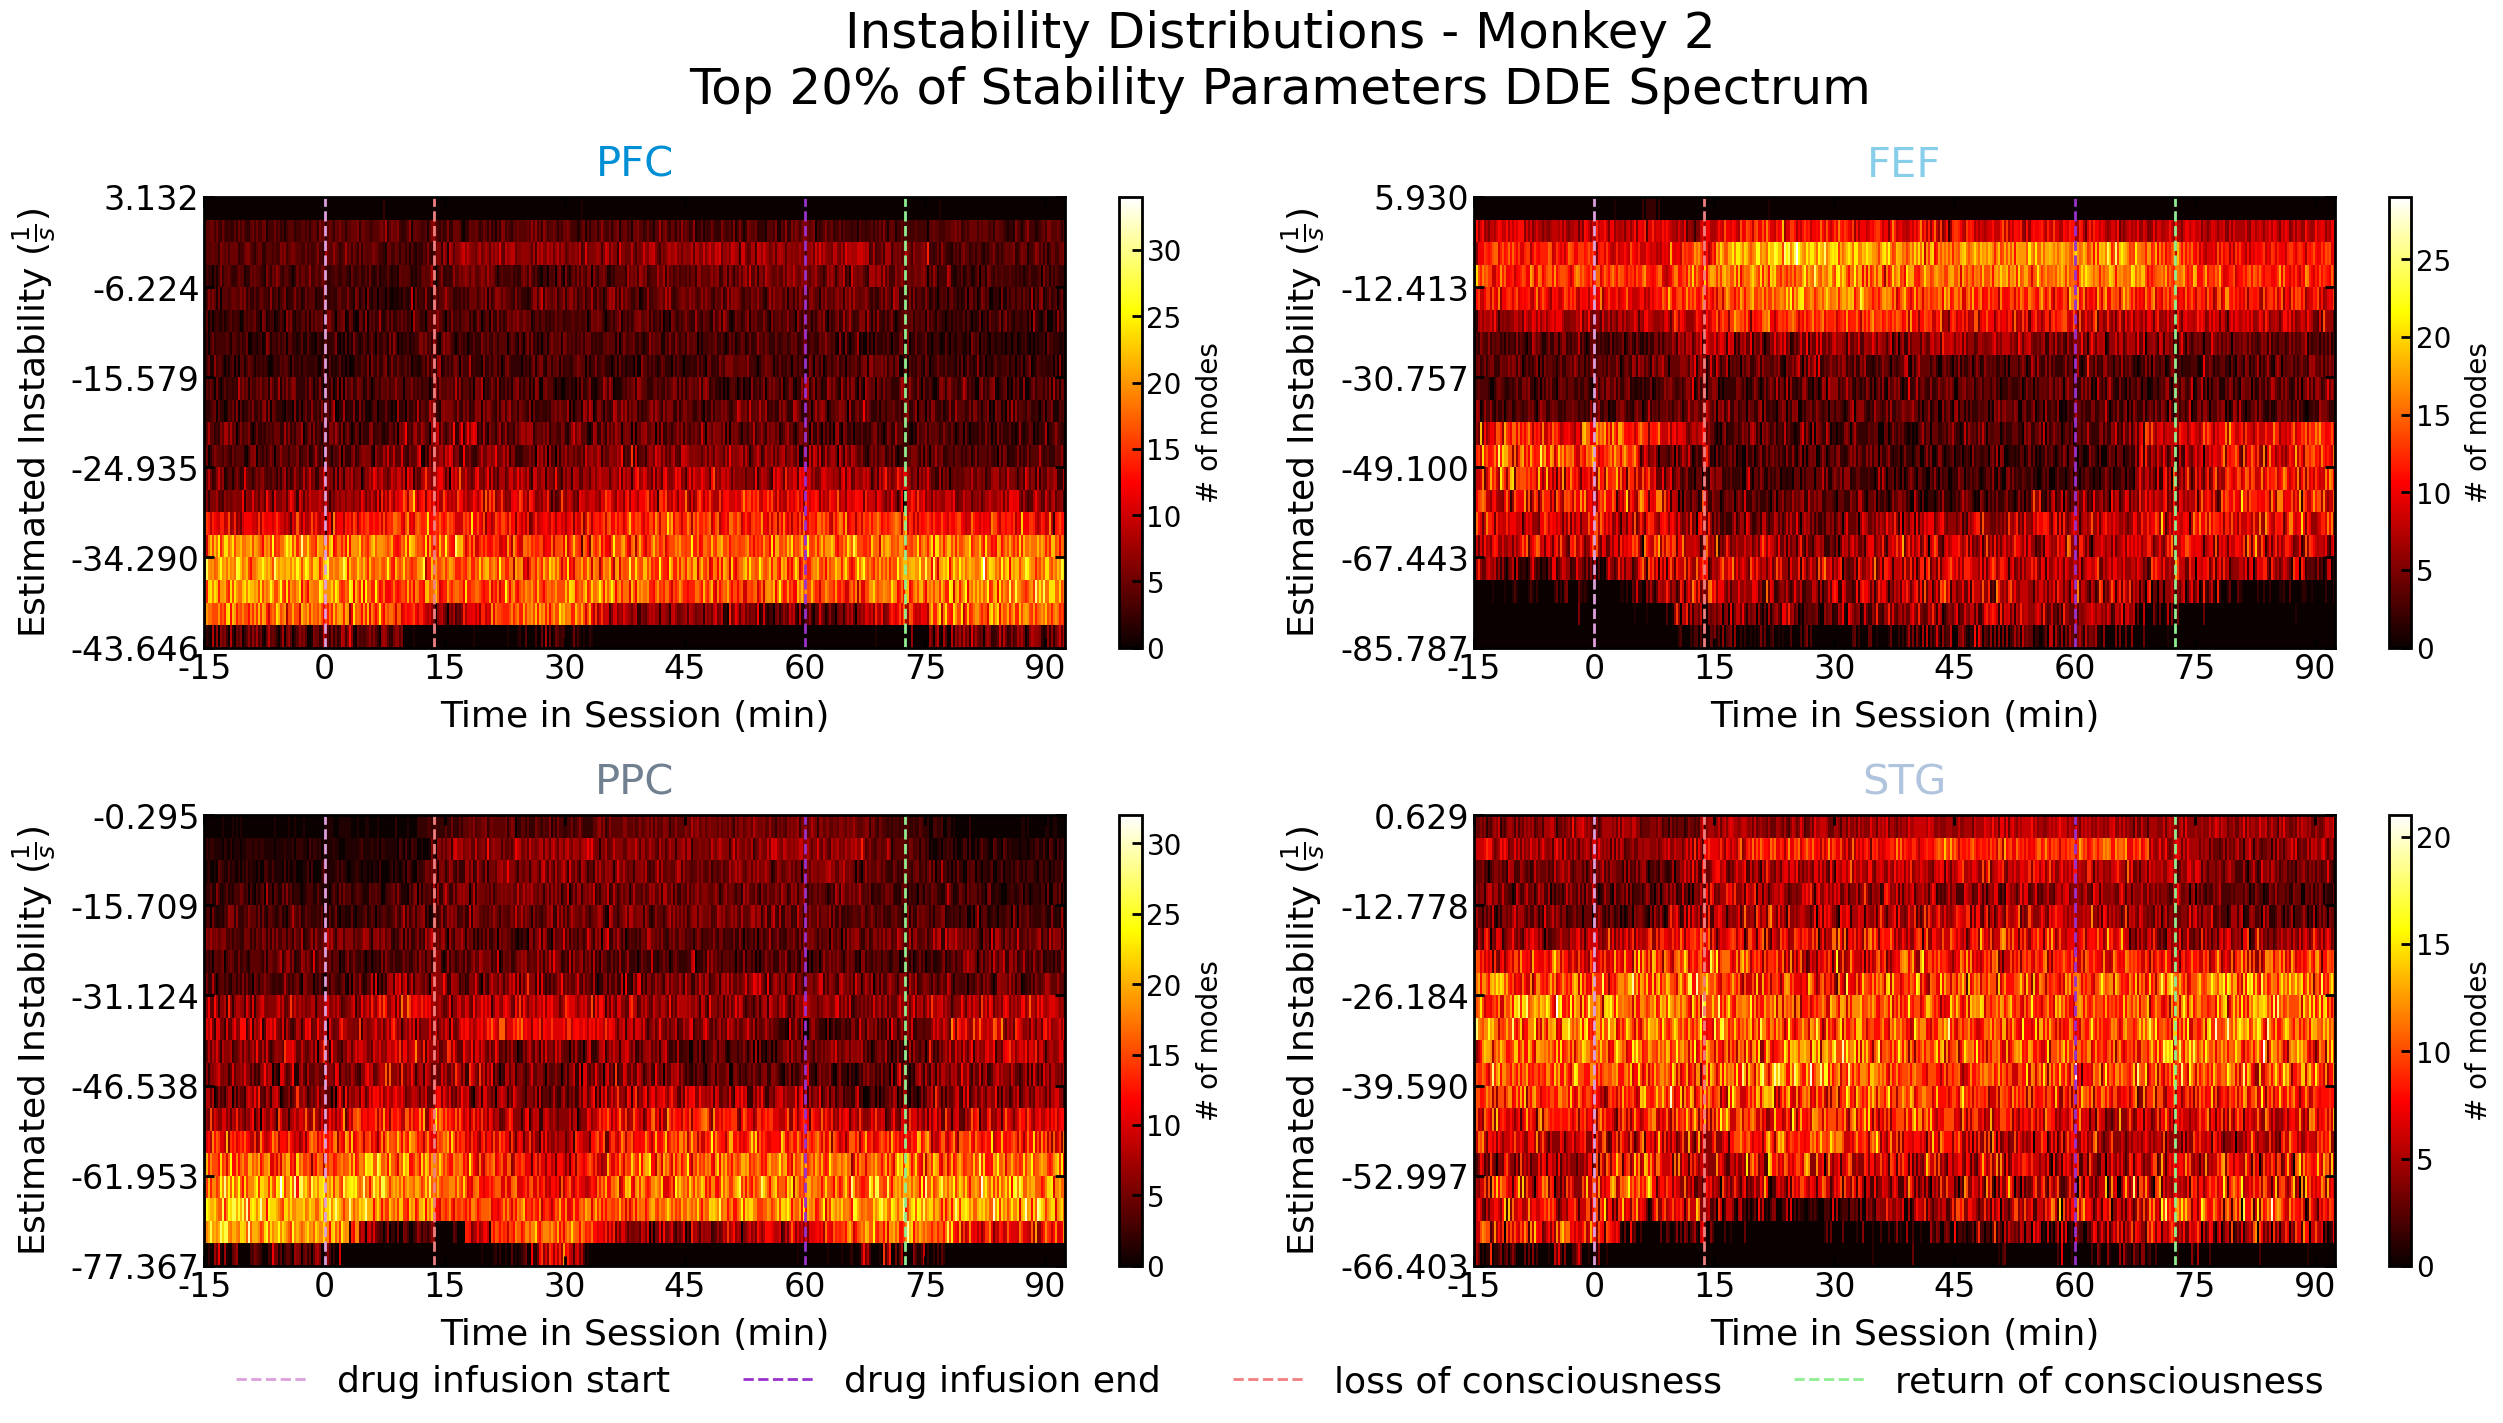

In [170]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'indigo'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

percentile_low = 0
percentile_high = 20

# filter_inds = np.logical_and(results_dict[list(results_dict.keys())[0]].start_time >= session_info['drugStart'][0] - 15*60, results_dict[list(results_dict.keys())[0]].start_time <= eyes_open + 20*60)
# time_vals = (results_dict[list(results_dict.keys())[0]][filter_inds].start_time - session_info['drugStart'][0])/60
filter_times = True

start_times = results_dict[list(results_dict.keys())[0]].start_time
stride = start_times.iloc[1] - start_times.iloc[0]

if percentile_low == 0:
    percentile_str = f"Top {percentile_high}% of Stability Parameters"
else:
    percentile_str = f"Top {percentile_low}% to {percentile_high}% of Stability Parameters"

# fig = plt.figure(figsize=(38, 7))

# areas = ['CPB', '7b', 'FEF', 'vlPFC', 'all']
areas = ['CPB', '7b', 'FEF', 'vlPFC']

fig = plt.figure(figsize=(26, 14))
for i, area in enumerate(areas):
    if area == 'all':
        plt.subplot(1, 3, 3)
    else:
        if 'all' in areas:
            if area == 'vlPFC':
                index = 1
            elif area == 'FEF':
                index = 2
            elif area == '7b':
                index = 4
            elif area == 'CPB':
                index = 5
            plt.subplot(2, 3, index)
        else:
            if area == 'vlPFC':
                index = 1
            elif area == 'FEF':
                index = 2
            elif area == '7b':
                index = 3
            elif area == 'CPB':
                index = 4
            plt.subplot(2, 2, index)
    if filter_times:
        filter_inds = np.logical_and(results_dict[area].start_time >= session_info['drugStart'][0] - 15*60, results_dict[area].start_time <= eyes_open + 20*60)
    else:
        filter_inds = [True]*len(results_dict[area])
    stab_params = results_dict[area][filter_inds].stability_params.apply(lambda x: x[int(percentile_low*len(x)/100):int(percentile_high*len(x)/100)])
    emin = np.hstack(stab_params.to_numpy()).min()
    emax = np.hstack(stab_params.to_numpy()).max()                                                                        
                                                                         
    bin_nums = 20
    bins = [(emax - emin)*i/bin_nums + emin for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((len(stab_params), bin_nums))
    log_density=False
    for t in range(criticality_prob_dist.shape[0]):
        if not log_density:
            criticality_prob_dist[t] = np.histogram(stab_params.iloc[t], bins=bins)[0]
        else:
            criticality_prob_dist[t] = [np.log(d) for d in np.histogram(stab_params.iloc[t], bins=bins, density=True)[0] if d > 0]
    
    plt.pcolormesh(criticality_prob_dist.T, cmap='hot')
    # plt.xticks([int(i*60/stride) for i in np.arange(0, 120, 20)], np.arange(0, 120, 20))
    plt.yticks(np.arange(0, bin_nums + 1, 4), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 4)]], fontsize=24)
#     num_xticks = 7
#     xtick_step = int(criticality_prob_dist.shape[0]/num_xticks)
    x_step = 15 # mins
    xtick_locs = np.arange(0, int(criticality_prob_dist.shape[0]), x_step*60/stride)
    plt.xticks(xtick_locs, [int(loc*stride/60) - 15 for loc in xtick_locs], fontsize=24)
    plt.xlabel('Time in Session (min)', fontsize=26)
    plt.ylabel('Estimated Instability' + r' ($\frac{1}{s}$)', fontsize=26)
    plt.title(area_labels[area], c=area_colors[area], fontsize=30)
    lns = []
    lns.append(plt.axvline((session_info['drugStart'][0] - session_info['drugStart'][0] + 15*60)/stride, color='plum', linestyle='--', label=f"drug infusion start"))
    lns.append(plt.axvline((session_info['drugEnd'][1] - session_info['drugStart'][0] + 15*60)/stride, color='darkorchid', linestyle='--', label=f"drug infusion end"))
    lns.append(plt.axvline((eyes_close - session_info['drugStart'][0] + 15*60)/stride, linestyle='--', color='lightcoral', label='loss of consciousness'))
    lns.append(plt.axvline((eyes_open - session_info['drugStart'][0] + 15*60)/stride, linestyle='--', color='lightgreen', label='return of consciousness'))
    cbar = plt.colorbar(label='# of modes' if not log_density else 'log density')
monkey_num = 2 if 'Jones' in session else 1
plt.suptitle(f"Instability Distributions - Monkey {monkey_num}\n{percentile_str} DDE Spectrum", fontsize=36)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, ncol=4, bbox_to_anchor=(0.5, 0), fontsize=26, loc='center')
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, f"neural_ret3_{session}.png"), transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'indigo'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

percentile_low = 0
percentile_high = 20

filter_inds = np.logical_and(results_dict[list(results_dict.keys())[0]].start_time >= session_info['drugStart'][0] - 15*60, results_dict[list(results_dict.keys())[0]].start_time <= eyes_open + 20*60)
time_vals = (results_dict[list(results_dict.keys())[0]][filter_inds].start_time - session_info['drugStart'][0])/60

if percentile_low == 0:
    percentile_str = f"Top {percentile_high}% of Stability Parameters"
else:
    percentile_str = f"Top {percentile_low}% to {percentile_high}% of Stability Parameters"

# fig = plt.figure(figsize=(38, 7))

areas = ['CPB', '7b', 'FEF', 'vlPFC', 'all']

fig = plt.figure(figsize=(37, 8))
for i, area in enumerate(areas):
    if area == 'all':
        plt.subplot(1, 5, 5)
    else:
        if area == 'vlPFC':
            index = 1
        elif area == 'FEF':
            index = 2
        elif area == '7b':
            index = 3
        elif area == 'CPB':
            index = 4
        plt.subplot(1, 5, index)
    stab_params = results_dict[area][filter_inds].stability_params.apply(lambda x: x[int(percentile_low*len(x)/100):int(percentile_high*len(x)/100)])
    emin = np.hstack(stab_params.to_numpy()).min()
    emax = np.hstack(stab_params.to_numpy()).max()                                                                        
                                                                         
    bin_nums = 40
    bins = [(emax - emin)*i/bin_nums + emin for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((len(stab_params), bin_nums))
    log_density=False
    for t in range(criticality_prob_dist.shape[0]):
        if not log_density:
            criticality_prob_dist[t] = np.histogram(stab_params.iloc[t], bins=bins)[0]
        else:
            criticality_prob_dist[t] = [np.log(d) for d in np.histogram(stab_params.iloc[t], bins=bins, density=True)[0] if d > 0]
    
    plt.pcolormesh(criticality_prob_dist.T, cmap='hot')
    # plt.xticks([int(i*60/stride) for i in np.arange(0, 120, 20)], np.arange(0, 120, 20))
    plt.yticks(np.arange(0, bin_nums + 1, 4), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 4)]], fontsize=24)
    x_step = 15 # mins
    xtick_locs = np.arange(0, int(criticality_prob_dist.shape[0]*stride/60), x_step)
    plt.xticks(np.arange(0, int(criticality_prob_dist.shape[0]*stride/60), x_step), [int(loc*60/stride) - 15 for loc in xtick_locs], fontsize=24)
    plt.xlabel('Time in Session (min)', fontsize=26)
    plt.ylabel('Estimated Instability' + r' ($\frac{1}{s}$)', fontsize=26)
    plt.title(area_labels[area], c=area_colors[area], fontsize=30)
    lns = []
    lns.append(plt.axvline((session_info['drugStart'][0] - session_info['drugStart'][0])/60 + 15, color='plum', linestyle='--', label=f"drug infusion start"))
    lns.append(plt.axvline((session_info['drugEnd'][1] - session_info['drugStart'][0])/60 + 15, color='darkorchid', linestyle='--', label=f"drug infusion end"))
    lns.append(plt.axvline((eyes_close - session_info['drugStart'][0])/60 + 15, linestyle='--', color='lightcoral', label='loss of consciousness'))
    lns.append(plt.axvline((eyes_open - session_info['drugStart'][0])/60 + 15, linestyle='--', color='lightgreen', label='return of consciousness'))
    plt.colorbar(label='# of modes' if not log_density else 'log density')
monkey_num = 2 if 'Jones' in session else 1
plt.suptitle(f"Instability Distributions - Monkey {monkey_num}\n{percentile_str} DDE Spectrum", fontsize=36)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, ncol=4, bbox_to_anchor=(0.5, 0), fontsize=26, loc='center')
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, f"neural_ret3_{session}.png"), transparent=True, bbox_inches='tight')
plt.show()